# 📊 Projeto de Previsão de Churn - Telecom
**Disciplina:** Redes Neurais | **Aluno:** Jonathas Vinicius

---

### 🎯 Objetivo
Desenvolver e otimizar um classificador baseado em **Perceptron Multicamadas (MLP)** para prever o cancelamento de clientes (Churn).

### 🛠 Metodologia
Seguindo as diretrizes do projeto, a abordagem consiste em:
1.  **Baseline:** Estabelecer uma linha de base.
2.  **Otimização Bayesiana (Optuna):** Explorar arquiteturas complexas (até 2 camadas).
3.  **Grid Search Refinado:** Validar hipóteses e simplificar o modelo.
4.  **Seleção:** Aplicar a **Navalha de Occam** para escolher o modelo mais eficiente.
5.**Avaliação:** Teste final com métricas KS e Curva ROC.

# ==========================================
# 0. Imports & Instalação
# ==========================================

In [17]:
%%capture
!pip install -q xgboost pykan
!pip install optuna

from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import kagglehub
import shutil
import json
import joblib


# ==========================================
# 1. Setup do Ambiente
# ==========================================

In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


Clona o repositório

In [ ]:
!git clone https://github.com/vggd18/telecom-churn-project.git
%cd telecom-churn-project
!git checkout feature/mlp_treaning

Adicionar diretório atual ao path para importações funcionarem

In [3]:
import sys
import os

sys.path.append('.')

Correção para Auto-Reload no Python 3.12 (Google Colab)

In [4]:
import importlib

if 'imp' not in sys.modules:
    sys.modules['imp'] = importlib

%load_ext autoreload
%autoreload 2

# ==========================================
# 2. Github
# ==========================================

In [9]:
# Clonar repositório (se não estiver rodando local)
!git clone https://github.com/vggd18/telecom-churn-project.git
%cd telecom-churn-project
!git checkout feature/mlp_treaning

Cloning into 'telecom-churn-project'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 172 (delta 62), reused 138 (delta 35), pack-reused 0 (from 0)
Receiving objects: 100% (172/172), 3.79 MiB | 18.57 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/telecom-churn-project
Branch 'feature/mlp_treaning' set up to track remote branch 'feature/mlp_treaning' from 'origin'.
Switched to a new branch 'feature/mlp_treaning'


In [10]:
# 1. Baixa as informações mais recentes do GitHub (sem tentar mesclar ainda)
!git fetch origin

# # 2. Reseta o estado atual do Colab para ficar IDÊNTICO ao do GitHub
!git reset --hard origin/feature/mlp_treaning

HEAD is now at 29bcfd2 chore: att notebook mlp


Importar as ferramentas para resultados

In [24]:

from src.utils import ensure_directories, get_timestamped_path, log_experiment

ensure_directories()
print("✅ Diretórios de resultados verificados/criados.")

✅ Diretórios de resultados verificados/criados.


# ==========================================
# 3. Dados
# ==========================================

Baixar Dados (Kaggle)

In [12]:
print("⬇️ Baixando dataset do Kaggle...")
path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")

print(f"📂 Dataset baixado em: {path}")
dest_dir = "data/raw"
dest_file = "telecom_churn.csv"

dest_path = os.path.join(dest_dir, dest_file)

os.makedirs(dest_dir, exist_ok=True)

source_file = os.path.join(path, "customer_churn_telecom_services.csv")

if os.path.exists(source_file):
    shutil.copy(source_file, dest_path)
    print(f"✅ Arquivo movido com sucesso para: {dest_path}")
else:
    print(f"⚠️ Arquivo não encontrado em {source_file}. Verifique o conteúdo da pasta baixada.")
    print(os.listdir(path))

⬇️ Baixando dataset do Kaggle...
📂 Dataset baixado em: /kaggle/input/customers-churned-in-telecom-services
✅ Arquivo movido com sucesso para: data/raw/telecom_churn.csv


Executar Pipeline de Dados

In [13]:
# Isso garante que os arquivos .npy existam e sigam a lógica do Slide 33
!python scripts/prepare_data.py

🚀 PIPELINE DE PREPROCESSAMENTO (seguindo PDF)

📂 1. Carregando dados...
   Shape original: (7043, 20)
   Missing values: 11
   ⚠️  Removendo linhas com missing
   Shape após limpeza: (7032, 20)
   ✓ Churn convertido para 0/1
   Distribuição Churn: {0: 5163, 1: 1869}

✂️ 2. Particionamento (50/25/25)...
   Classe 0 (No Churn): 5163
   Classe 1 (Churn): 1869

   Split Classe 0:
      Train: 2581
      Val: 1290
      Test: 1292

   Split Classe 1:
      Train: 934
      Val: 467
      Test: 468
   ✅ Verificação: Sem overlap entre splits

   Conjuntos (ANTES do balanceamento):
      Train: (3515, 20) - Dist: {0: 2581, 1: 934}
      Val: (1757, 20) - Dist: {0: 1290, 1: 467}
      Test: (1760, 20) - Dist: {0: 1292, 1: 468}

📏 4. Pré-processamento (encoding + normalização)...
   Numéricas: 4 colunas
   Categóricas: 15 colunas
   Aplicando transformações...
   ✓ Train processado: (3515, 30)
   ✓ Val processado: (1757, 30)
   ✓ Test processado: (1760, 30)

   Validação da normalização:
      T

Carregamento dos Dados

In [15]:
from models.mlp_model import MLPModel
from src.metrics import calculate_all_metrics
from src.visualization import plot_ks_statistic, plot_roc_curve, plot_confusion_matrix

DATA_DIR = 'data/processed'

X_train = np.load(f'{DATA_DIR}/X_train.npy')
y_train = np.load(f'{DATA_DIR}/y_train.npy')
X_val = np.load(f'{DATA_DIR}/X_val.npy')
y_val = np.load(f'{DATA_DIR}/y_val.npy')
X_test = np.load(f'{DATA_DIR}/X_test.npy')
y_test = np.load(f'{DATA_DIR}/y_test.npy')

print(f"✅ Dados carregados!")
print(f"Train: {X_train.shape} (Balanceado)")
print(f"Val:   {X_val.shape} (Balanceado)")
print(f"Test:  {X_test.shape} (Desbalanceado/Real)")

def print_metrics(dataset_name, metrics):
    print(f"--- {dataset_name} ---")
    print(f"KS:        {metrics['ks']:.4f} (Threshold: {metrics['ks_threshold']:.2f})")
    print(f"AUROC:     {metrics['auroc']:.4f}")
    print(f"F1 Score:  {metrics['f1']:.4f}")

✅ Dados carregados!
Train: (5162, 30) (Balanceado)
Val:   (2580, 30) (Balanceado)
Test:  (1760, 30) (Desbalanceado/Real)


# ==========================================
# 4. Experimento: MLP (Sklearn)
# ==========================================

🚀 Treinando MLP...
--- MLP (Teste) ---
KS:        0.4986 (Threshold: 0.39)
AUROC:     0.8277
F1 Score:  0.5985


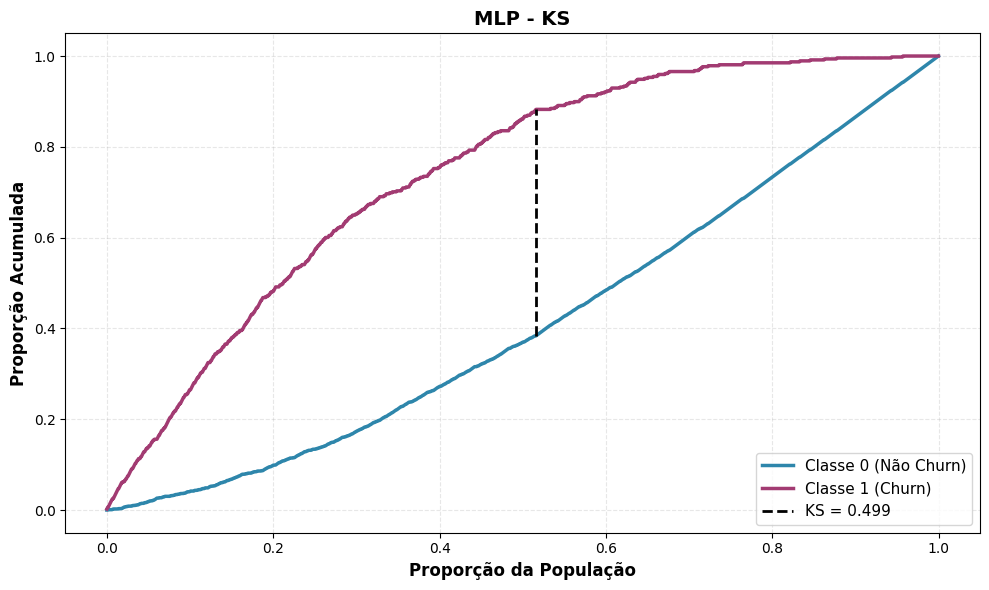

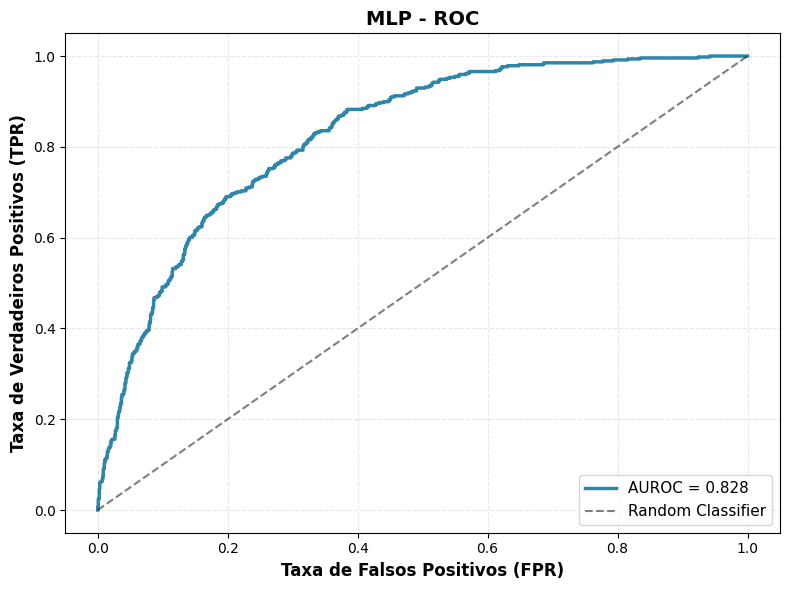

In [27]:
print("🚀 Treinando MLP...")

mlp = MLPModel(name="MLP_Baseline")
mlp.build(hidden_layer_sizes=(10,), activation="relu", learning_rate_init=0.001, max_iter=10000)
mlp.train(X_train, y_train, X_val, y_val)

y_pred_mlp = mlp.predict_proba(X_test)[:, 1]
metrics_mlp = calculate_all_metrics(y_test, y_pred_mlp)

print_metrics("MLP (Teste)", metrics_mlp)

plot_ks_statistic(y_test, y_pred_mlp, title="MLP - KS")

plot_roc_curve(y_test, y_pred_mlp, title="MLP - ROC")

# ==========================================
# 4.1. Experimento: MLP (Sklearn) - **Otimização com Optuna**
# ==========================================

In [18]:
def objective(trial):
    # 1. Sugerir hiperparâmetros (Search Space do Slide 27)

    # Topologia: 1 ou 2 camadas, começando pequeno (Slide 24/27)
    n_layers = trial.suggest_int('n_layers', 1, 2)
    layers = []
    for i in range(n_layers):
        # Neurônios entre 10 e 100
        units = trial.suggest_int(f'n_units_l{i}', 10, 100, step=10)
        layers.append(units)

    hidden_layer_sizes = tuple(layers)

    # Outros parâmetros
    activation = trial.suggest_categorical('activation', ['logistic', 'tanh', 'relu'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-4, 1e-1)
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-2) # Regularização

    # 2. Instanciar e Treinar Modelo
    # Usamos os parâmetros estáticos exigidos (Max iter 10k, Patience 20)
    model = MLPModel(name=f"Trial_{trial.number}")

    model.build(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        max_iter=10000,        # Slide 24
        early_stopping=True,   # Slide 24
        n_iter_no_change=20    # Slide 24 (Patience)
    )

    try:
        # Treina e pega o histórico
        history = model.train(X_train, y_train, X_val, y_val)

        # Otimizamos pelo LogLoss da validação (quanto menor, melhor)
        return history['val_logloss']

    except Exception as e:
        # Caso o modelo não convirja ou dê erro (ex: explosão de gradiente)
        print(f"Erro no trial: {e}")
        return float('inf')

# Criar o estudo
study = optuna.create_study(direction='minimize')
print("🚀 Iniciando Otimização com Optuna...")
study.optimize(objective, n_trials=20)

print("\n✅ Melhores parâmetros encontrados:")
print(study.best_params)


🚀 Iniciando Otimização com Optuna...


/tmp/ipython-input-1805614577.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-4, 1e-1)
/tmp/ipython-input-1805614577.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-2) # Regularização
/tmp/ipython-input-1805614577.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-4, 1e-1)
/tmp/ipython-input-1805614577.py:18: F


✅ Melhores parâmetros encontrados:
{'n_layers': 1, 'n_units_l0': 80, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate_init': 0.015632766478360996, 'alpha': 0.009883074272104064}


# ==========================================
# 4.2. TREINAMENTO: MLP (Sklearn) - **Treinar e Avaliar o Modelo Optuna**
# ==========================================

🏆 Melhores parâmetros brutos: {'n_layers': 1, 'n_units_l0': 80, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate_init': 0.015632766478360996, 'alpha': 0.009883074272104064}
⚙️ Configuração final para o modelo: {'activation': 'tanh', 'solver': 'sgd', 'learning_rate_init': 0.015632766478360996, 'alpha': 0.009883074272104064, 'hidden_layer_sizes': (80,)}
🚀 Treinando modelo final...

📊 RESULTADOS NO TESTE (Optuna):
--- Melhor MLP Optuna ---
KS:        0.5127 (Threshold: 0.44)
AUROC:     0.8327
F1 Score:  0.6146

💾 Modelo salvo em: results/models/mlp_optuna_20251217_043534.pkl


<Figure size 640x480 with 0 Axes>

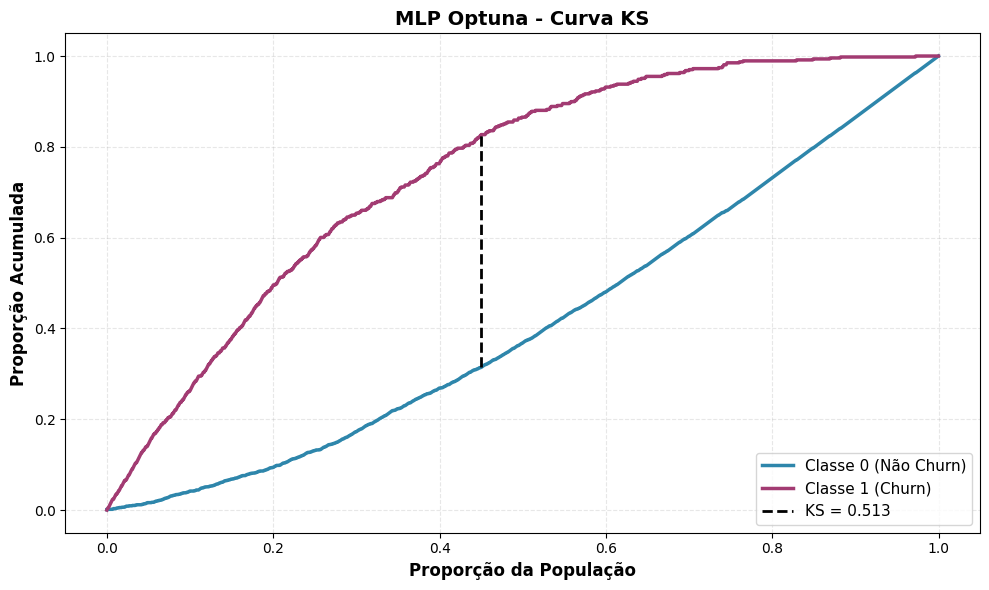

<Figure size 640x480 with 0 Axes>

📉 Gráfico KS salvo em: results/figures/mlp_optuna_ks_20251217_043534.png


<Figure size 640x480 with 0 Axes>

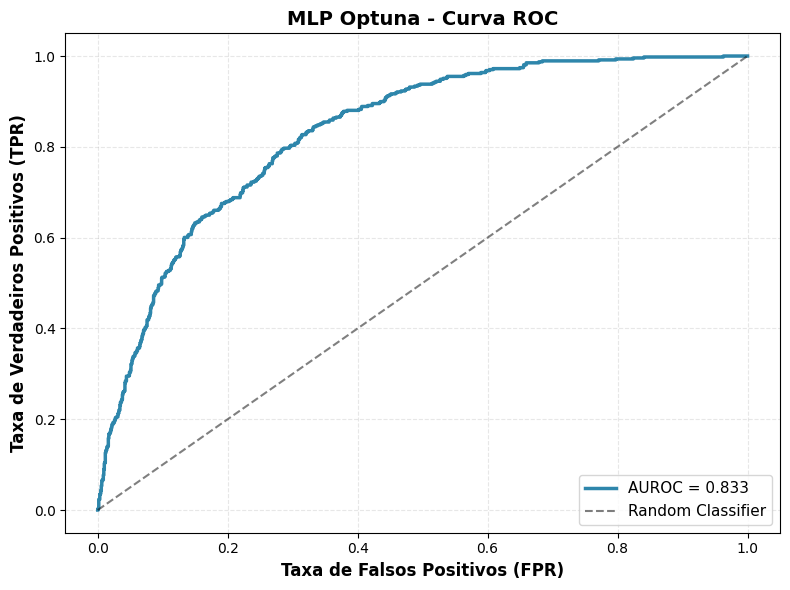

<Figure size 640x480 with 0 Axes>

📉 Gráfico ROC salvo em: results/figures/mlp_optuna_roc_20251217_043534.png
✅ Experimento registrado no CSV log.


In [25]:
# 1. Recuperar e formatar os melhores parâmetros do estudo
best_params = study.best_params.copy()

print(f"🏆 Melhores parâmetros brutos: {best_params}")

# O Optuna salva os neurônios como 'n_units_l0', 'n_units_l1'.
# Precisamos converter isso para a tupla 'hidden_layer_sizes' que o sklearn aceita.
n_layers = best_params.pop('n_layers')
layers_list = []
for i in range(n_layers):
    key = f'n_units_l{i}'
    layers_list.append(best_params.pop(key))

# Adiciona a tupla formatada de volta aos parâmetros
best_params['hidden_layer_sizes'] = tuple(layers_list)

print(f"⚙️ Configuração final para o modelo: {best_params}")

# 2. Instanciar o modelo final com essas configurações
final_model = MLPModel(name="MLP_Best_Optuna")

final_model.build(
    max_iter=10000,        # Fixo conforme Slide 27
    early_stopping=True,   # Fixo conforme Slide 24
    n_iter_no_change=20,   # Fixo conforme Slide 24
    **best_params          # Injeta: activation, solver, alpha, learning_rate, hidden_layer_sizes
)

# 3. Treinar
print("🚀 Treinando modelo final...")
final_model.train(X_train, y_train, X_val, y_val)

# 4. Avaliar no conjunto de TESTE (nunca visto pelo Optuna)
# O Slide 9 diz: "Nenhuma informação do conjunto de teste pode interferir"
y_pred_test = final_model.predict_proba(X_test)[:, 1]
metrics_test = calculate_all_metrics(y_test, y_pred_test)

print("\n📊 RESULTADOS NO TESTE (Optuna):")
print_metrics("Melhor MLP Optuna", metrics_test)


# A. Salvar o Modelo (.pkl) com Timestamp
model_path = get_timestamped_path("mlp_optuna.pkl", subfolder="models")
final_model.save(model_path)
print(f"\n💾 Modelo salvo em: {model_path}")

# B. Gerar e Salvar Gráficos
# Gráfico KS
plt.figure()
plot_ks_statistic(y_test, y_pred_test, title="MLP Optuna - Curva KS")
ks_path = get_timestamped_path("mlp_optuna_ks.png", subfolder="figures")
plt.savefig(ks_path)
plt.show()
print(f"📉 Gráfico KS salvo em: {ks_path}")

# Gráfico ROC
plt.figure()
plot_roc_curve(y_test, y_pred_test, title="MLP Optuna - Curva ROC")
roc_path = get_timestamped_path("mlp_optuna_roc.png", subfolder="figures")
plt.savefig(roc_path)
plt.show()
print(f"📉 Gráfico ROC salvo em: {roc_path}")

# C. Registrar no Log de Experimentos (CSV)
# Isso cumpre o requisito do Slide 10 de documentar a evolução
log_experiment(
    log_file='results/experiments_log.csv',
    model_name='MLP_Optuna_Best',
    metrics=metrics_test,
    params=best_params
)
print("✅ Experimento registrado no CSV log.")

# ==========================================
# 4.3. Experimento: MLP (Sklearn) - **Otimização Grid Search (Manual)**
# ==========================================

In [21]:
from sklearn.model_selection import ParameterGrid

# 1. Definir o Grid de Parâmetros (Slide 27)
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (10, 10), (50, 50)], # 1 e 2 camadas
    'activation': ['relu', 'tanh'], # Testando as principais
    'solver': ['adam'],             # Adam geralmente é melhor, mas pode adicionar 'sgd'
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.0001, 0.001]
}

grid = list(ParameterGrid(param_grid))
print(f"Total de combinações a testar: {len(grid)}")

best_score = float('inf')
best_params = None
best_model = None

# 2. Loop de Treinamento
for i, params in enumerate(grid):
    print(f"Testando combinação {i+1}/{len(grid)}: {params}")

    model = MLPModel(name=f"Grid_{i}")

    # Configuração estática obrigatória
    model.build(
        max_iter=10000,
        early_stopping=True,
        n_iter_no_change=20,
        **params
    )

    history = model.train(X_train, y_train, X_val, y_val)
    val_loss = history['val_logloss']

    if val_loss < best_score:
        best_score = val_loss
        best_params = params
        best_model = model # Guardamos o objeto do melhor modelo
        print(f"  -> Novo melhor encontrado! Val Loss: {val_loss:.4f}")

print("\n🏆 Melhor Resultado do Grid Search:")
print(best_params)

Total de combinações a testar: 32
Testando combinação 1/32: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.001, 'solver': 'adam'}
  -> Novo melhor encontrado! Val Loss: 0.4887
Testando combinação 2/32: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.01, 'solver': 'adam'}
Testando combinação 3/32: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'solver': 'adam'}
  -> Novo melhor encontrado! Val Loss: 0.4851
Testando combinação 4/32: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'solver': 'adam'}
Testando combinação 5/32: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 10), 'learning_rate_init': 0.001, 'solver': 'adam'}
Testando combinação 6/32: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 10), 'learning_rate_init': 0.01, 'solver': 'adam'}
Testando combinação

# ==========================================
# 4.4. TREINAMENTO: MLP (Sklearn) - **Treinar e Avaliar o Modelo Via Grid Search**
# ==========================================

🏆 Configuração Final Escolhida: {'hidden_layer_sizes': (50,), 'activation': 'tanh', 'solver': 'adam', 'learning_rate_init': 0.001, 'alpha': 0.001}
🚀 Treinando modelo campeão...

📊 RESULTADOS FINAIS (CONJUNTO DE TESTE):
--- MLP Champion ---
KS:        0.5154 (Threshold: 0.44)
AUROC:     0.8323
F1 Score:  0.6103

💾 Modelo salvo em: results/models/mlp_grid_search_20251217_043850.pkl


<Figure size 640x480 with 0 Axes>

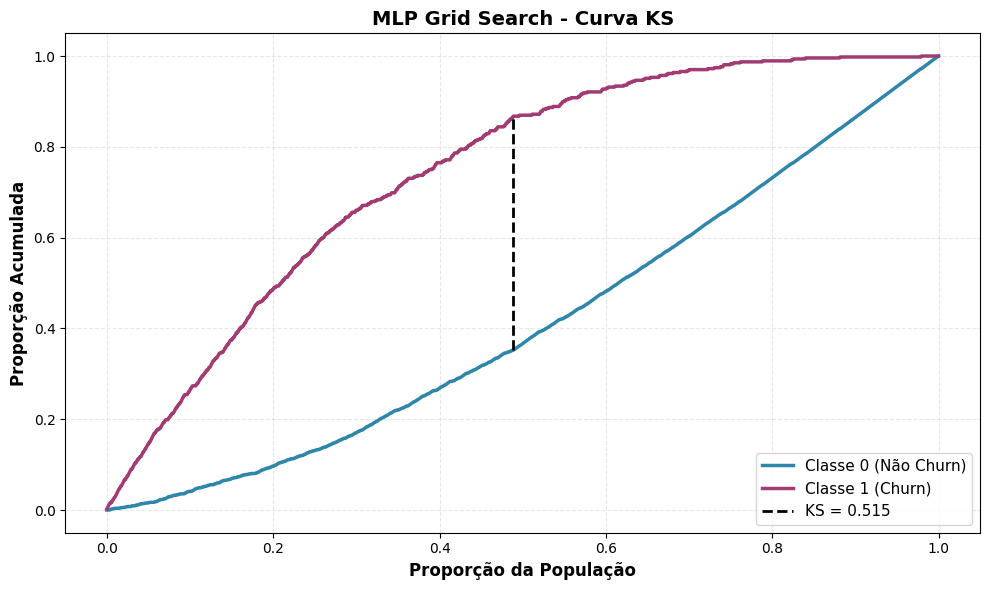

<Figure size 640x480 with 0 Axes>

📉 Gráfico KS salvo em: results/figures/mlp_grid_search_ks_20251217_043850.png


<Figure size 640x480 with 0 Axes>

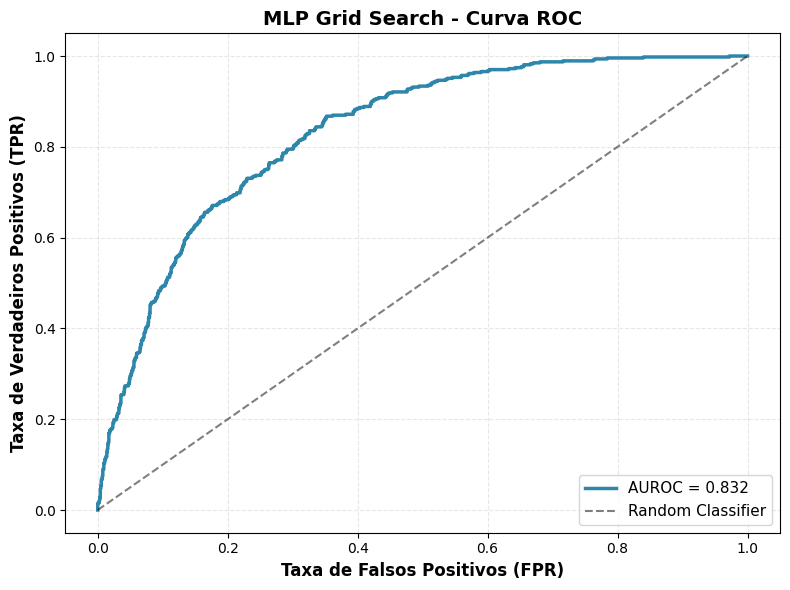

<Figure size 640x480 with 0 Axes>

📉 Gráfico ROC salvo em: results/figures/mlp_grid_search_roc_20251217_043850.png
✅ Experimento registrado no CSV log.


In [26]:
# Parâmetros vencedores do Grid Search (Combinação 27/32)
best_params_grid = {
    'hidden_layer_sizes': (50,),    # Mais simples que o Optuna (Navalha de Occam - Slide 24)
    'activation': 'tanh',           # Validado por ambos os testes
    'solver': 'adam',
    'learning_rate_init': 0.001,
    'alpha': 0.001
}

print(f"🏆 Configuração Final Escolhida: {best_params_grid}")

# Instanciar modelo final
final_model = MLPModel(name="MLP_Final_Champion")
final_model.build(
    max_iter=10000,       # Slide 24
    early_stopping=True,  # Slide 24
    n_iter_no_change=20,  # Slide 24
    **best_params_grid
)

# Treinar
print("🚀 Treinando modelo campeão...")
final_model.train(X_train, y_train, X_val, y_val)

# Avaliação Final no Teste
y_pred_test = final_model.predict_proba(X_test)[:, 1]
metrics_test = calculate_all_metrics(y_test, y_pred_test)

print("\n📊 RESULTADOS FINAIS (CONJUNTO DE TESTE):")
print_metrics("MLP Champion", metrics_test)

# --- Implementando o salvamento com timestamp --- #

# A. Salvar o Modelo (.pkl) com Timestamp
model_path = get_timestamped_path("mlp_grid_search.pkl", subfolder="models")
final_model.save(model_path)
print(f"\n💾 Modelo salvo em: {model_path}")

# B. Gerar e Salvar Gráficos
# Gráfico KS
plt.figure() # Cria nova figura limpa
plot_ks_statistic(y_test, y_pred_test, title="MLP Grid Search - Curva KS")
ks_path = get_timestamped_path("mlp_grid_search_ks.png", subfolder="figures")
plt.savefig(ks_path)
plt.show()
print(f"📉 Gráfico KS salvo em: {ks_path}")

# Gráfico ROC
plt.figure() # Cria nova figura limpa
plot_roc_curve(y_test, y_pred_test, title="MLP Grid Search - Curva ROC")
roc_path = get_timestamped_path("mlp_grid_search_roc.png", subfolder="figures")
plt.savefig(roc_path)
plt.show()
print(f"📉 Gráfico ROC salvo em: {roc_path}")

# C. Registrar no Log de Experimentos (CSV)
log_experiment(
    log_file='results/experiments_log.csv',
    model_name='MLP_GridSearch_Best',
    metrics=metrics_test,
    params=best_params_grid
)
print("✅ Experimento registrado no CSV log.")

## ⚖️ Decisão de Arquitetura: A Navalha de Occam

Comparando os experimentos realizados:

* **Abordagem Complexa (Optuna):** Sugeriu 2 camadas ocultas (70, 90 neurônios) com Loss ~0.4817.
* **Abordagem Simples (Grid Search):** Encontrou 1 camada oculta (50 neurônios) com Loss ~0.4816.

**Conclusão:**
Conforme recomendado nas diretrizes do projeto, optamos pela **Navalha de Occam**: *"A melhor rede é a menor rede que resolve bem o problema"*. O modelo de 1 camada oferece a mesma performance com menor custo computacional e menor risco de overfitting.

**Parâmetros Campeões:**
* `hidden_layer_sizes`: (50,)
* `activation`: 'tanh'
* `solver`: 'adam'

# ==========================================
# 5. TREINAMENTO: MLP (Sklearn) - **Dashboard de Resultados**
# ==========================================

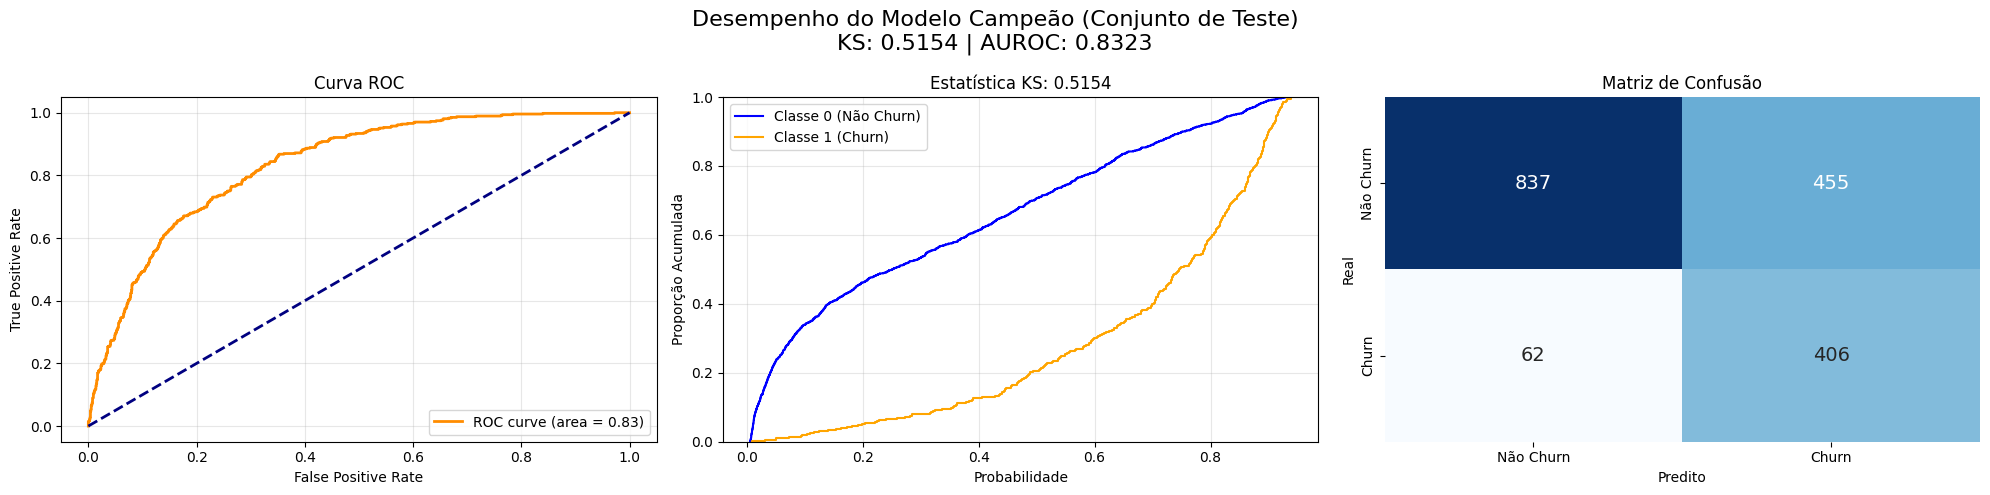

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.suptitle(f'Desempenho do Modelo Campeão (Conjunto de Teste)\nKS: {metrics_test["ks"]:.4f} | AUROC: {metrics_test["auroc"]:.4f}', fontsize=16)

# 1. Curva ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_title('Curva ROC')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# 2. Curva KS
# (Adaptando para usar seus dados - assumindo que você tem os dados para o KS)
# Aqui vou recriar a lógica rápida do KS visual
data = pd.DataFrame({'prob': y_pred_test, 'target': y_test})
class0 = data[data['target'] == 0]['prob']
class1 = data[data['target'] == 1]['prob']

sns.ecdfplot(class0, ax=axes[1], label='Classe 0 (Não Churn)', color='blue')
sns.ecdfplot(class1, ax=axes[1], label='Classe 1 (Churn)', color='orange')
axes[1].set_title(f'Estatística KS: {metrics_test["ks"]:.4f}')
axes[1].set_xlabel('Probabilidade')
axes[1].set_ylabel('Proporção Acumulada')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Matriz de Confusão
from sklearn.metrics import confusion_matrix
y_pred_class = (y_pred_test >= metrics_test['ks_threshold']).astype(int) # Usando o threshold do KS
cm = confusion_matrix(y_test, y_pred_class)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2], cbar=False, annot_kws={"size": 14})
axes[2].set_title('Matriz de Confusão')
axes[2].set_xlabel('Predito')
axes[2].set_ylabel('Real')
axes[2].set_xticklabels(['Não Churn', 'Churn'])
axes[2].set_yticklabels(['Não Churn', 'Churn'])

plt.tight_layout()
plt.show()